# **EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code references: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

**Data Details:**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

**Experimental Details:**
**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.


In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
import gzip
from anndata import AnnData as ad
from tabulate import tabulate
from scipy.io import mmread

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy import stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
bulk_path = f"{actual_path}/../data/EXP4/bulk/GSE217517_RAW/"
diss_bulk_path = f"{actual_path}/../data/EXP4/bulk_dissociated/GSE217517_RAW/"
disspolyA_bulk_path= f"{actual_path}/../data/EXP4/bulk_dissociated_polyA/GSE217517_RAW/"
sc_path = f"{actual_path}/../data/EXP4/single_cell/GSE217517_RAW/"
clabels_path = f"{actual_path}/../data/EXP4/single_cell/cell_labels/"
random_seed = 88
bulks_type = 'real'

#if this is the first time running,
#the names in the files are expected will be the ones from OMNIBUS.
first_run = False

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [3]:
#bulks read
bulk_names = dict()
bulk_names[1] = ["GSM6720935_bulk_chunk_ribo_2251_STAR.tsv"]
bulk_names[2] = ["GSM6720936_bulk_chunk_ribo_2267_STAR.tsv"]
bulk_names[3] = ["GSM6720937_bulk_chunk_ribo_2283_STAR.tsv"]
bulk_names[4] = ["GSM6720938_bulk_chunk_ribo_2293_STAR.tsv"]
bulk_names[5] = ["GSM6720939_bulk_chunk_ribo_2380_STAR.tsv"]
bulk_names[6] = ["GSM6720940_bulk_chunk_ribo_2428_STAR.tsv"]
bulk_names[7] = ["GSM6720941_bulk_chunk_ribo_2467_STAR.tsv"]
bulk_names[8] = ["GSM6720942_bulk_chunk_ribo_2497_STAR.tsv"]

In [4]:
#reading in the bulks and putting them into a dictionary
bulks = dict()
for bulk_name in bulk_names:
    bulks_path_all = os.path.join(bulk_path, f"{bulk_names[bulk_name][0]}")
    bulks_path_all = Path(bulks_path_all)
    current_bulk = pd.read_csv(bulks_path_all, sep="\t")
    current_bulk = current_bulk.T
    #keeping only row with total counts, discarding forward and backward
    current_bulk.index = range(0,current_bulk.shape[0])
    current_bulk.columns = current_bulk.iloc[0]
    current_bulk = current_bulk.drop(index=[0,2,3], axis =0)
    current_bulk = current_bulk.drop(labels =['N_multimapping', 'N_noFeature',  'N_ambiguous'], axis=1)
    bulks[bulk_name] = current_bulk
bulks[1]    

,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000236601,...,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000278782,ENSG00000277761,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
1,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [5]:
#dissociated bulks read
diss_bulk_names = dict()
diss_bulk_names[1] = ["GSM6720943_bulk_dissociated_ribo_2251_STAR.tsv"]
diss_bulk_names[2] = ["GSM6720944_bulk_dissociated_ribo_2267_STAR.tsv"]
diss_bulk_names[3] = ["GSM6720945_bulk_dissociated_ribo_2283_STAR.tsv"]
diss_bulk_names[4] = ["GSM6720946_bulk_dissociated_ribo_2293_STAR.tsv"]
diss_bulk_names[5] = ["GSM6720947_bulk_dissociated_ribo_2380_STAR.tsv"]
diss_bulk_names[6] = ["GSM6720948_bulk_dissociated_ribo_2428_STAR.tsv"]
diss_bulk_names[7] = ["GSM6720949_bulk_dissociated_ribo_2467_STAR.tsv"]
diss_bulk_names[8] = ["GSM6720950_bulk_dissociated_ribo_2497_STAR.tsv"]

In [6]:
#reading in the bulks and putting them into a dictionary
diss_bulks = dict()
for bulk_name in diss_bulk_names:
    bulks_path_all = os.path.join(diss_bulk_path, f"{diss_bulk_names[bulk_name][0]}")
    bulks_path_all = Path(bulks_path_all)
    current_bulk = pd.read_csv(bulks_path_all, sep="\t")
    current_bulk = current_bulk.T
    #keeping only row with total counts, discarding forward and backward
    current_bulk.index = range(0,current_bulk.shape[0])
    current_bulk.columns = current_bulk.iloc[0]
    current_bulk = current_bulk.drop(index=[0,2,3], axis =0)
    current_bulk = current_bulk.drop(labels =['N_multimapping', 'N_noFeature',  'N_ambiguous'], axis=1)
    diss_bulks[bulk_name] = current_bulk
diss_bulks[1]    

,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000236601,...,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000278782,ENSG00000277761,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
1,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated PolyA tail captured bulks

In [7]:
#dissociated polyA bulks read
disspolyA_bulk_names = dict()
disspolyA_bulk_names[1] = ["GSM6720951_bulk_dissociated_polyA_2251_STAR.tsv"]
disspolyA_bulk_names[2] = ["GSM6720952_bulk_dissociated_polyA_2267_STAR.tsv"]
disspolyA_bulk_names[3] = ["GSM6720953_bulk_dissociated_polyA_2283_STAR.tsv"]
disspolyA_bulk_names[4] = ["GSM6720954_bulk_dissociated_polyA_2293_STAR.tsv"]
disspolyA_bulk_names[5] = ["GSM6720955_bulk_dissociated_polyA_2380_STAR.tsv"]
disspolyA_bulk_names[6] = ["GSM6720956_bulk_dissociated_polyA_2428_STAR.tsv"]
disspolyA_bulk_names[7] = ["GSM6720957_bulk_dissociated_polyA_2467_STAR.tsv"]
disspolyA_bulk_names[8] = ["GSM6720958_bulk_dissociated_polyA_2497_STAR.tsv"]

In [8]:
#reading in the bulks and putting them into a dictionary
disspolyA_bulks = dict()
for bulk_name in disspolyA_bulk_names:
    disspolyA_bulks_path_all = os.path.join(disspolyA_bulk_path, f"{disspolyA_bulk_names[bulk_name][0]}")
    disspolyA_bulks_path_all = Path(disspolyA_bulks_path_all)
    current_bulk = pd.read_csv(disspolyA_bulks_path_all, sep="\t")
    current_bulk = current_bulk.T
    #keeping only row with total counts, discarding forward and backward
    current_bulk.index = range(0,current_bulk.shape[0])
    current_bulk.columns = current_bulk.iloc[0]
    current_bulk = current_bulk.drop(index=[0,2,3], axis =0)
    current_bulk = current_bulk.drop(labels =['N_multimapping', 'N_noFeature',  'N_ambiguous'], axis=1)
    disspolyA_bulks[bulk_name] = current_bulk
disspolyA_bulks[1]    

,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000236601,...,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000278782,ENSG00000277761,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
1,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


And Single-Cell Experiments

In [9]:
#dissociated bulks read
sc_names = dict()
sc_names[1] = ["GSM6720925","2251"]
sc_names[2] = ["GSM6720926","2267"]
sc_names[3] = ["GSM6720927","2283"]
sc_names[4] = ["GSM6720928","2293"]
sc_names[5] = ["GSM6720929","2380"]
sc_names[6] = ["GSM6720930","2428"]
sc_names[7] = ["GSM6720931","2467"]
sc_names[8] = ["GSM6720932","2497"]

In [10]:
#importing cell labels
labels = dict()
for sc_name in sc_names:
    label_path = os.path.join(clabels_path, f"{sc_name}/")
    label_path = os.path.join(label_path, f"{sc_names[sc_name][1]}_labels.txt")
    label_path = Path(label_path)
    current_labels = pd.read_csv(label_path, sep="\t")
    labels[sc_name] = current_labels
    print(labels[sc_name].shape)
    print(Counter(labels[sc_name]['cellType']))
labels[1]

(9464, 2)
Counter({'Plasma cells': 3265, 'Endothelial cells': 1830, 'Fibroblasts': 1354, 'T cells': 1041, 'Epithelial cells': 564, 'Macrophages': 412, 'Monocytes': 300, 'NK cells': 212, 'B cells': 178, 'DC': 152, 'pDC': 67, 'ILC': 62, 'Mast cells': 27})
(5345, 2)
Counter({'T cells': 2696, 'Epithelial cells': 945, 'Macrophages': 467, 'NK cells': 279, 'B cells': 220, 'DC': 205, 'Monocytes': 187, 'Fibroblasts': 149, 'pDC': 98, 'Endothelial cells': 60, 'Plasma cells': 35, 'Mast cells': 4})
(7627, 2)
Counter({'Epithelial cells': 2423, 'Fibroblasts': 2378, 'Macrophages': 1563, 'T cells': 679, 'Monocytes': 265, 'Endothelial cells': 163, 'NK cells': 156})
(10609, 2)
Counter({'T cells': 6947, 'NK cells': 1091, 'Macrophages': 1067, 'Epithelial cells': 408, 'Fibroblasts': 305, 'pDC': 262, 'DC': 188, 'Plasma cells': 166, 'B cells': 53, 'Endothelial cells': 51, 'Monocytes': 45, 'Mast cells': 14, 'Erythroid': 12})
(6300, 2)
Counter({'T cells': 1837, 'Fibroblasts': 1678, 'Epithelial cells': 996, 'Mon

,Barcode,cellType
0,AAACCCAAGATTGACA-1,Plasma cells
1,AAACCCAAGCATGGGT-1,B cells
2,AAACCCAAGTCACGCC-1,Endothelial cells
3,AAACCCAAGTCGAAGC-1,Plasma cells
4,AAACCCACACTTGTCC-1,T cells
...,...,...
9459,TTTGTTGGTAAGACCG-1,B cells
9460,TTTGTTGGTGGATTTC-1,DC
9461,TTTGTTGGTTTCGTTT-1,Plasma cells
9462,TTTGTTGTCAAACCCA-1,Macrophages


In [11]:
#function to create anndata objects from the Gene omnibus files from the orig. paper.
def create_adata(sc_path, sc_names, idx):

    #If it is first time running, uncomment lines to match text from Omnibus names
    if first_run:

        matrix_file_old = f"{sc_names[idx][0]}_single_cell_matrix_{sc_names[idx][1]}.mtx.gz"
        genes_file_old = f"{sc_names[idx][0]}_single_cell_features_{sc_names[idx][1]}.tsv.gz"
        barcodes_file_old = f"{sc_names[idx][0]}_single_cell_barcodes_{sc_names[idx][1]}.tsv.gz"
        
        #paths
        mat_path_old = os.path.join(sc_path, matrix_file_old)
        mat_path_old = Path(mat_path_old)
        gene_path_old = os.path.join(sc_path, genes_file_old)
        gene_path_old = Path(gene_path_old)
        barcode_path_old = os.path.join(sc_path, barcodes_file_old)
        barcode_path_old = Path(barcode_path_old)

    matrix_file = f"{sc_names[idx][0]}_single_cell_matrix.mtx.gz"
    genes_file = f"{sc_names[idx][0]}_single_cell_features.tsv.gz"
    barcodes_file = f"{sc_names[idx][0]}_single_cell_barcodes.tsv.gz"

    #prep paths
    mat_path = os.path.join(sc_path, matrix_file)
    mat_path = Path(mat_path)
    gene_path = os.path.join(sc_path, genes_file)
    gene_path = Path(gene_path)
    barcode_path = os.path.join(sc_path, barcodes_file)
    barcode_path = Path(barcode_path)

    if first_run:

        #renaming to open with scanpy function
        os.rename(mat_path_old, mat_path)
        os.rename(barcode_path_old, barcode_path)
        os.rename(gene_path_old, gene_path)

    # Create an AnnData object
    adata = sc.read_10x_mtx(sc_path, var_names='gene_symbols', 
                            make_unique=True, prefix=f"{sc_names[idx][0]}_single_cell_")

    return adata

In [12]:
adata_1 = create_adata(sc_path, sc_names, 1)
adata_2 = create_adata(sc_path, sc_names, 2)
adata_3 = create_adata(sc_path, sc_names, 3)
adata_4 = create_adata(sc_path, sc_names, 4)
adata_5 = create_adata(sc_path, sc_names, 5)
adata_6 = create_adata(sc_path, sc_names, 6)
adata_7 = create_adata(sc_path, sc_names, 7)
adata_8 = create_adata(sc_path, sc_names, 8)

Saving mapping of gene_ids to Ensemble genes:

In [13]:
gene_maps = pd.DataFrame(columns =["Name", "Ens"])
gene_maps["Name"] = adata_1.var.index
gene_maps["Ens"] = adata_1.var["gene_ids"].values
#save:
gene_maps.to_csv(f'{data_path}/gene_maps.csv')
gene_ids = gene_maps["Name"]
gene_ids = gene_ids.values
gene_ids

0        MIR1302-2HG
1            FAM138A
2              OR4F5
3         AL627309.1
4         AL627309.3
            ...     
36596     AC141272.1
36597     AC023491.2
36598     AC007325.1
36599     AC007325.4
36600     AC007325.2
Name: Name, Length: 36601, dtype: object

## Processing Single-Cell
 (This data is already processed and uploaded to GEO Omnibus as count matrices, so mostly doing QC)

Assign cell-types, from original paper.

In [15]:
#function to assign cell types to each anndata. 
def cut_and_assign_ct(adata, cell_meta):
    adata.var["gene_ids"] = adata.var.index
    #getting common cells between meta and count matrix
    common_cells = np.intersect1d([adata.obs.index], [cell_meta["Barcode"].values])
    common_cells= list(common_cells)
    #num of cells total
    print(f"cells in common = {len(common_cells)}")
    # Create a Boolean mask for common cells
    mask = adata.obs_names.isin(common_cells)
    # Subset the anndata object to include only common cells
    adata = adata[mask].copy()

    #make index the same to assign cell types
    cell_meta.index = cell_meta["Barcode"]
    cell_meta = cell_meta.loc[common_cells]
    adata.var["gene_ids"] = adata.var.index
    # Merge the two DataFrames based on the indexes from before
    merged_df = pd.merge(adata.obs, cell_meta, left_index=True, right_index=True)
    # Extract the cell type labels from the merged DataFrame
    cell_type_labels = merged_df["cellType"].values

    # Assign the cell type labels to the adata.obs DataFrame
    adata.obs["cell_types"] = cell_type_labels
    return adata

In [16]:
adata_1 = cut_and_assign_ct(adata_1, labels[1])
adata_2 = cut_and_assign_ct(adata_2, labels[2])
adata_3 = cut_and_assign_ct(adata_3, labels[3])
adata_4 = cut_and_assign_ct(adata_4, labels[4])
adata_5 = cut_and_assign_ct(adata_5, labels[5])
adata_6 = cut_and_assign_ct(adata_6, labels[6])
adata_7 = cut_and_assign_ct(adata_7, labels[7])
adata_8 = cut_and_assign_ct(adata_8, labels[8])

cells in common = 8842
cells in common = 5246
cells in common = 7541
cells in common = 10609
cells in common = 6300
cells in common = 283
cells in common = 6729
cells in common = 9313


In [17]:
#function to delete cells that are less than min_obs_count.
def delete_nonfreq(adata, min_obs_count):
   #calculate the number of observations for each cell type
    cell_type_counts = adata.obs['cell_types'].value_counts()

    #identify cell types with fewer than min_obs_count observations
    cell_types_to_delete = cell_type_counts[cell_type_counts < min_obs_count].index

    #Filter out the observations associated with these cell types
    adata_filtered = adata[~adata.obs['cell_types'].isin(cell_types_to_delete)]

    #update AnnData object
    adata = adata_filtered.copy()
    
    return adata

In [18]:
adata_1 = delete_nonfreq(adata_1, 30)
adata_2 = delete_nonfreq(adata_2, 30)
adata_3 = delete_nonfreq(adata_3, 30)
adata_4 = delete_nonfreq(adata_4, 30)
adata_5 = delete_nonfreq(adata_5, 30)
adata_6 = delete_nonfreq(adata_6, 30)
adata_7 = delete_nonfreq(adata_7, 30)
adata_8 = delete_nonfreq(adata_8, 30)

In [19]:
#function for processing according to the Scanpy recommendations 
def process_scapytutorial(adata):

    sc.pl.highest_expr_genes(adata, n_top=20, )

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]

    sc.pp.normalize_total(adata, target_sum=1e4)
    return adata

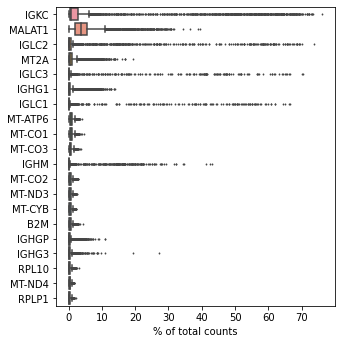

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


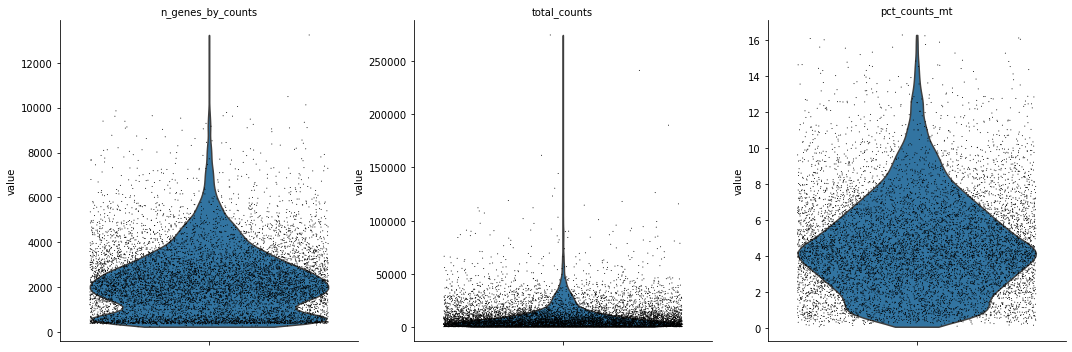

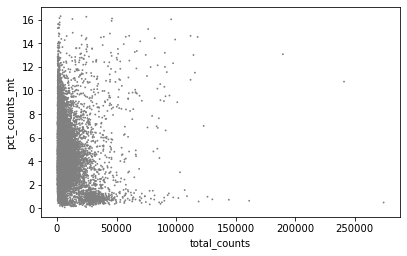

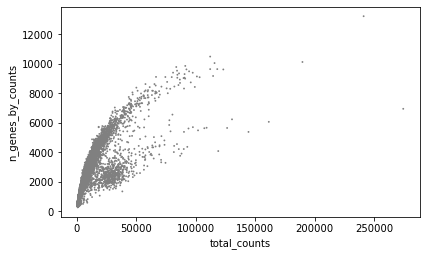

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


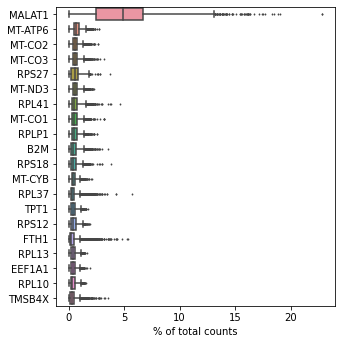

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


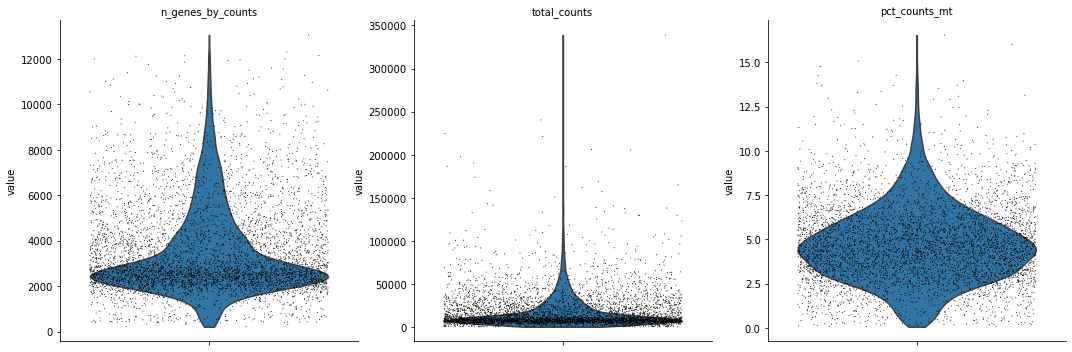

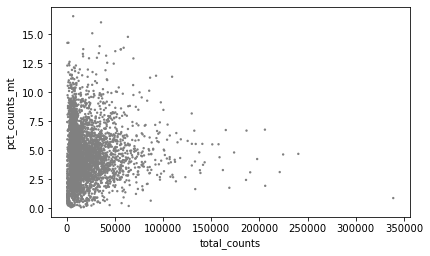

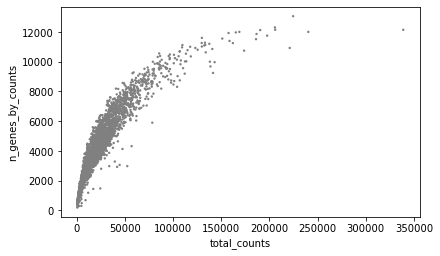

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


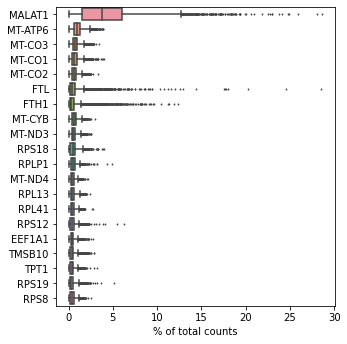

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


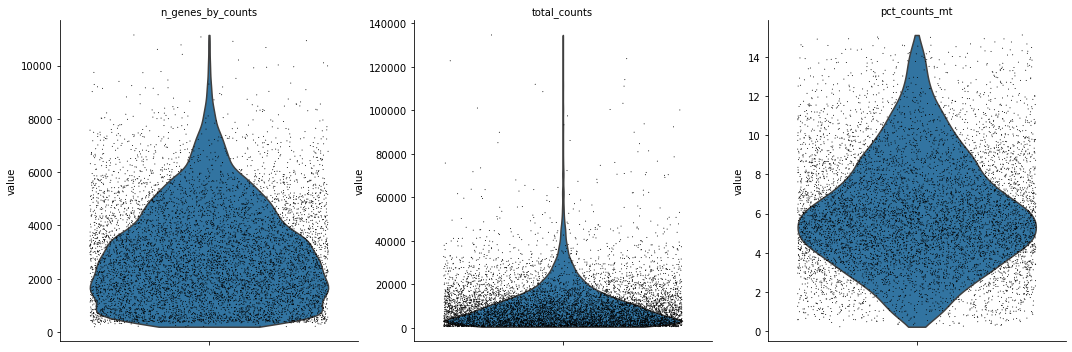

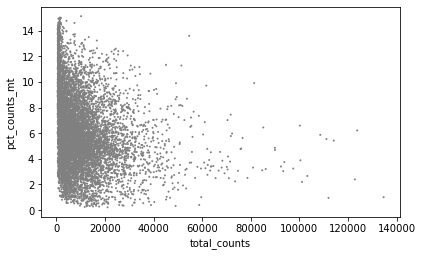

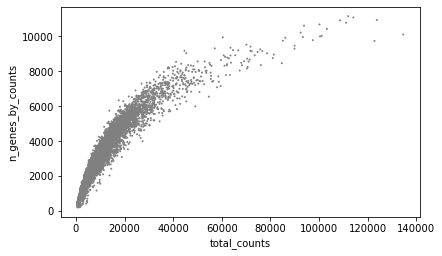

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


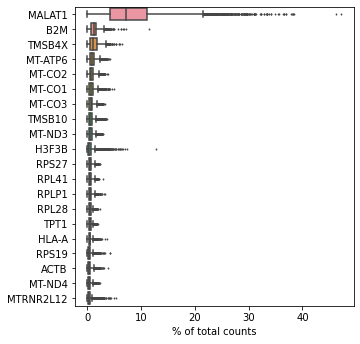

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


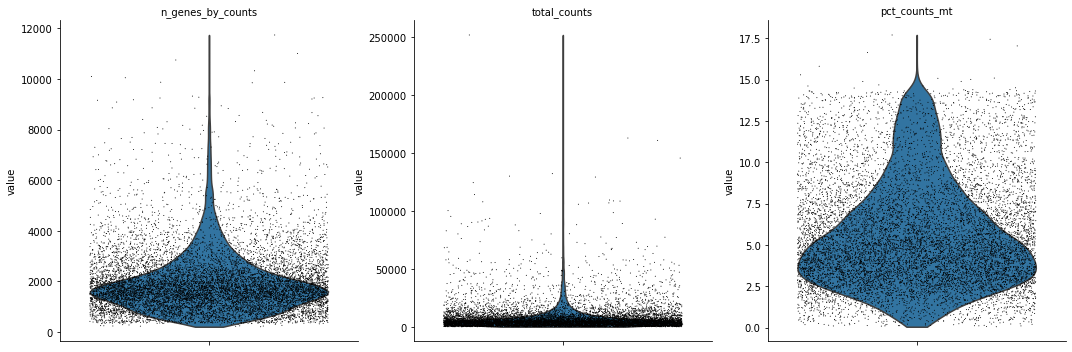

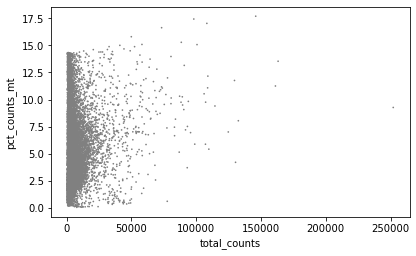

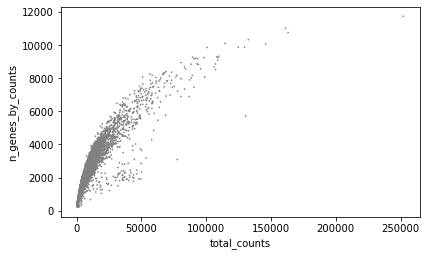

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


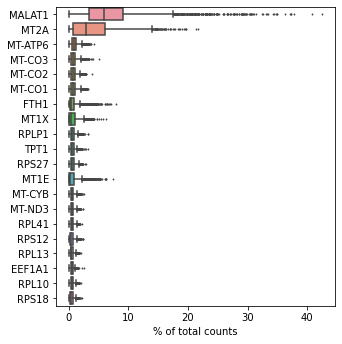

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


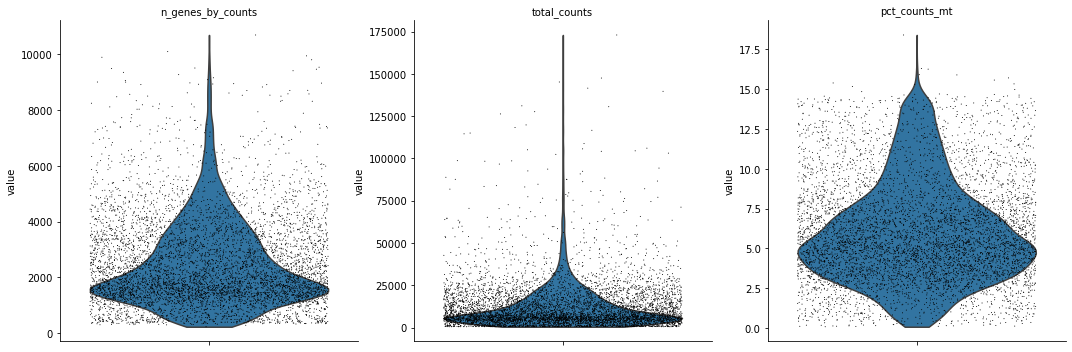

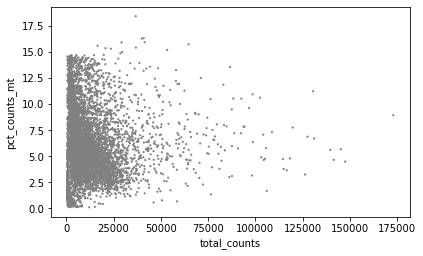

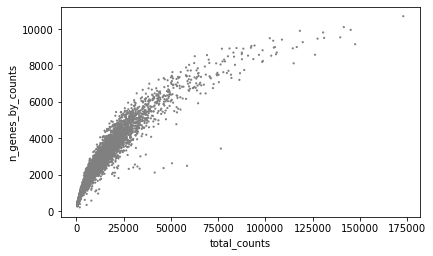

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


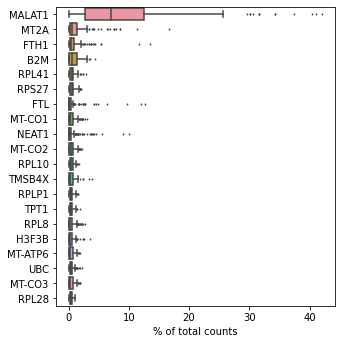

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


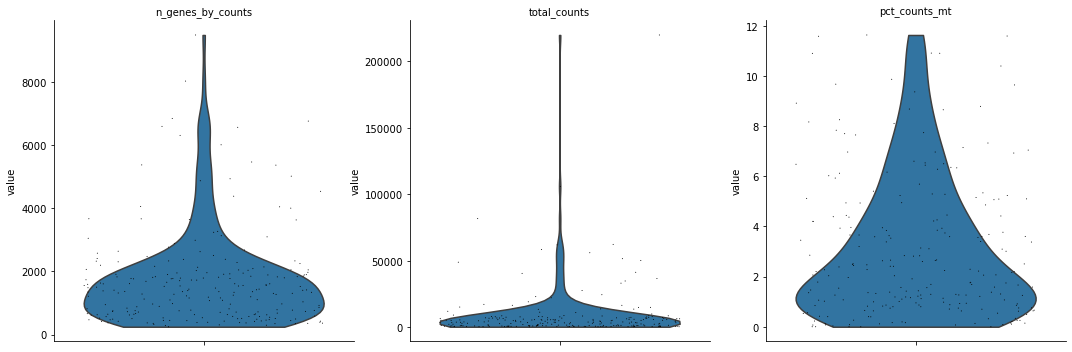

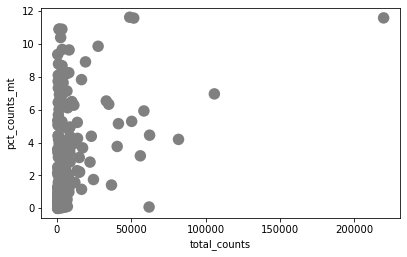

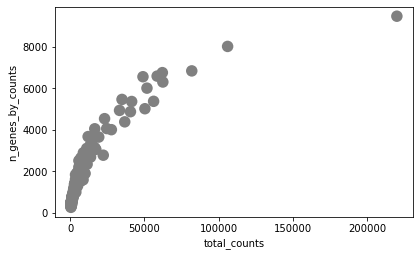

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


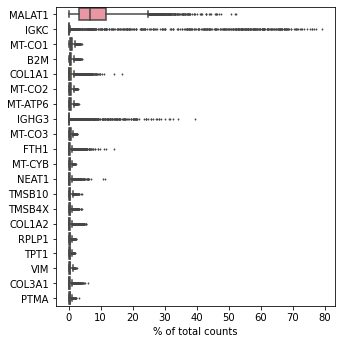

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


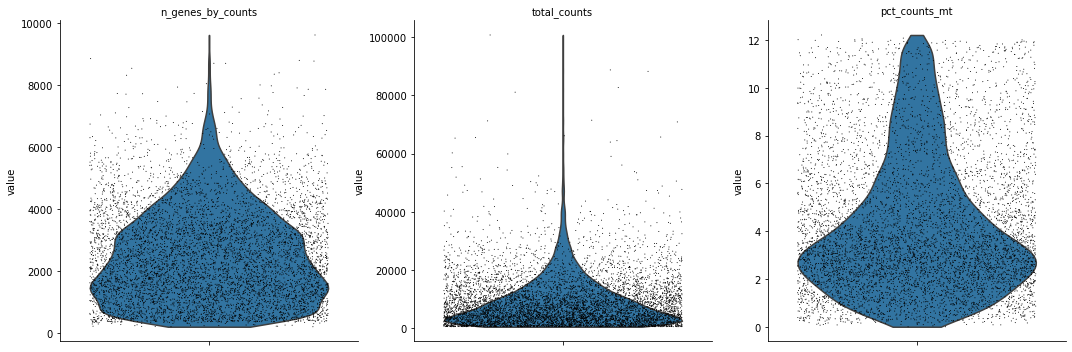

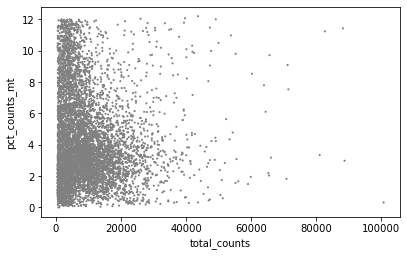

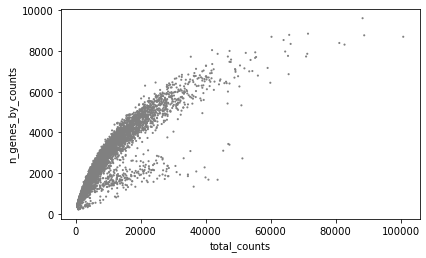

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


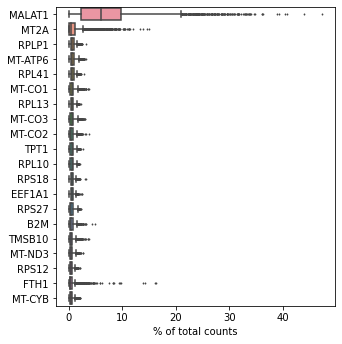

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


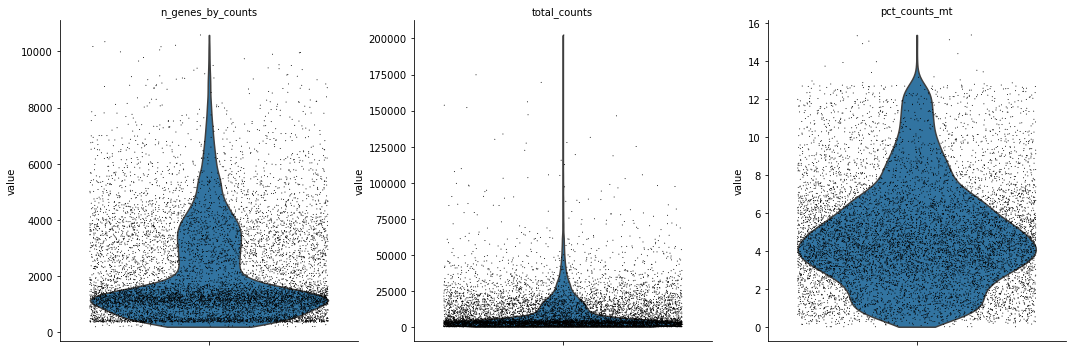

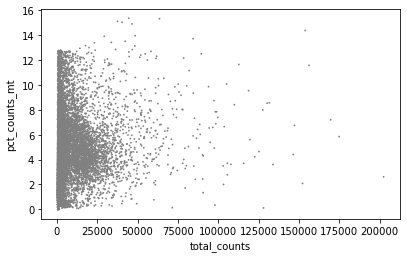

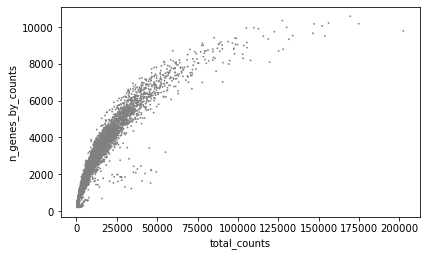

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
adata_1 = process_scapytutorial(adata_1)
adata_2 = process_scapytutorial(adata_2)
adata_3 = process_scapytutorial(adata_3)
adata_4 = process_scapytutorial(adata_4)
adata_5 = process_scapytutorial(adata_5)
adata_6 = process_scapytutorial(adata_6)
adata_7 = process_scapytutorial(adata_7)
adata_8 = process_scapytutorial(adata_8)

In [21]:
#function to plot umaps and PCA for each anndata
def pca_umaps(adata_):
    adata = adata_.copy()
    sc.pp.log1p(adata)
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['leiden', 'cell_types'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


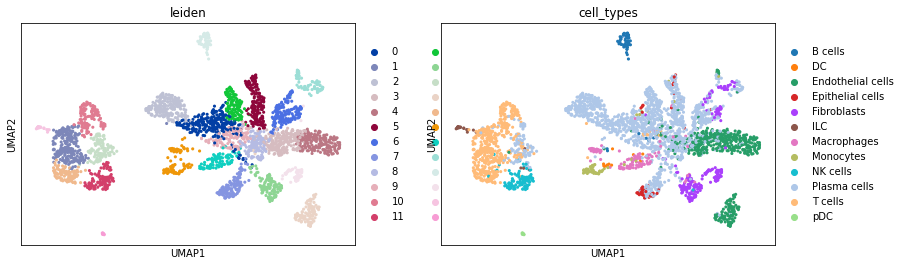

In [22]:
pca_umaps(adata_1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


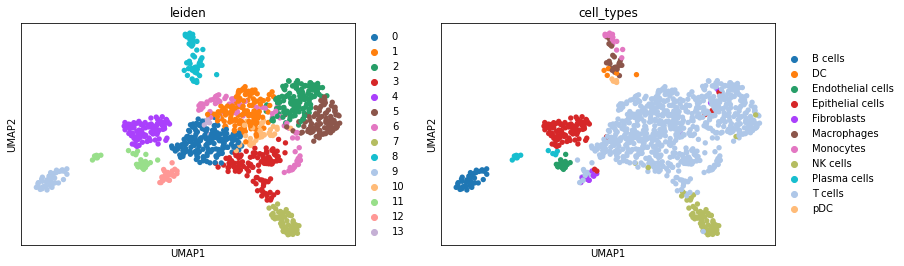

In [23]:
pca_umaps(adata_2)

         Falling back to preprocessing with `sc.pp.pca` and default params.


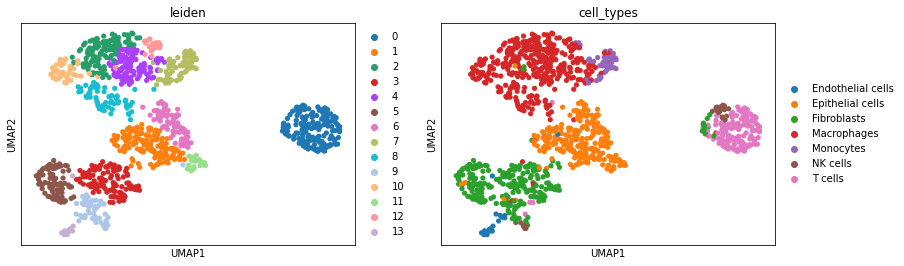

In [24]:
pca_umaps(adata_3)

         Falling back to preprocessing with `sc.pp.pca` and default params.


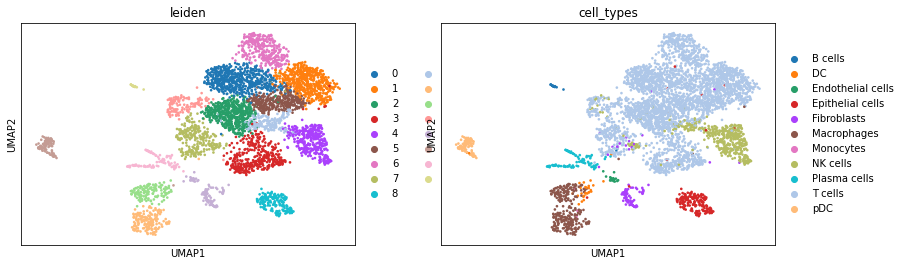

In [25]:
pca_umaps(adata_4)

         Falling back to preprocessing with `sc.pp.pca` and default params.


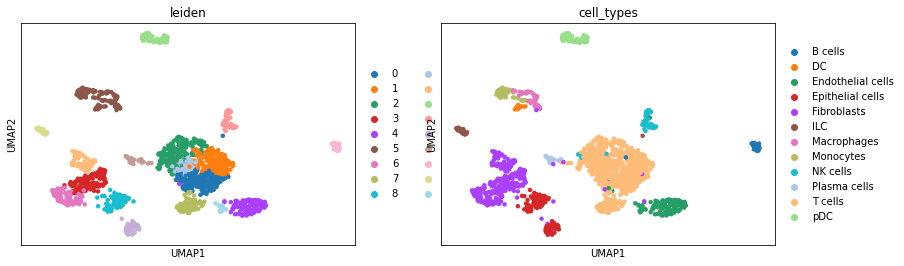

In [26]:
pca_umaps(adata_5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


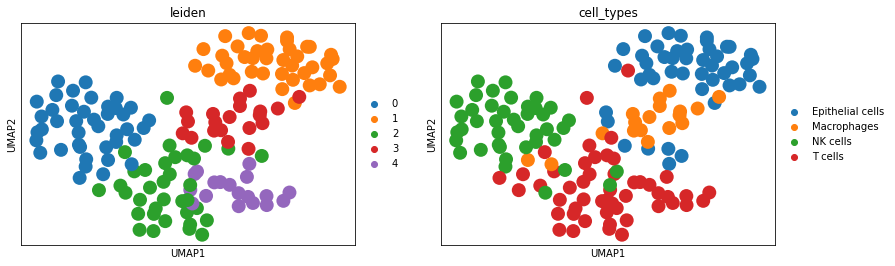

In [27]:
pca_umaps(adata_6)

         Falling back to preprocessing with `sc.pp.pca` and default params.


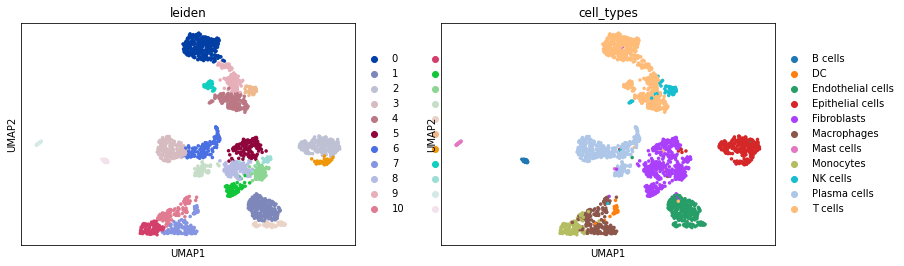

In [28]:
pca_umaps(adata_7)

         Falling back to preprocessing with `sc.pp.pca` and default params.


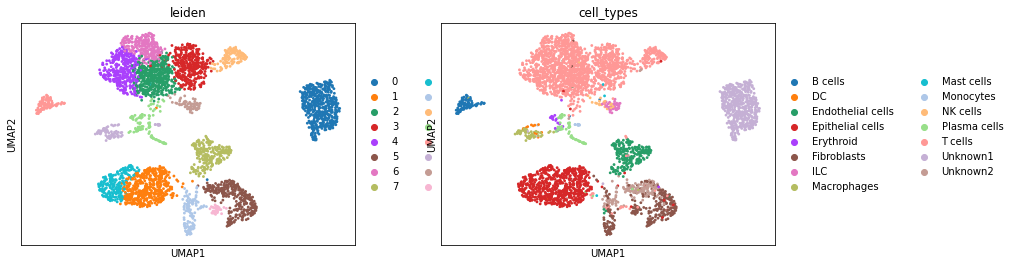

In [29]:
pca_umaps(adata_8)

## Formatting bulks and saving

Putting bulks together:

In [30]:
#putting all bulks together in DF
bulks_together = pd.DataFrame(columns = bulks[1].columns)
for num in bulks:
    bulks_together = pd.concat([bulks_together, bulks[num]])

bulks = bulks_together.copy()
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
bulks.columns = gene_ids
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7
2267,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
2283,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
2293,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
2380,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
2428,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
2467,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2497,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36


In [31]:
#putting all dissociated bulks together in DF
diss_bulks_together = pd.DataFrame(columns = diss_bulks[1].columns)
for num in diss_bulks:
    
    diss_bulks_together = pd.concat([diss_bulks_together, diss_bulks[num]])

diss_bulks = diss_bulks_together.copy()
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']

diss_bulks.columns = gene_ids
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
2251,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9
2267,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
2283,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
2293,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
2380,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
2428,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
2467,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2497,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28


In [32]:
#putting all disspolyAociated bulks polyA together in DF
disspolyA_bulks_together = pd.DataFrame(columns = disspolyA_bulks[1].columns)
for num in disspolyA_bulks:
    
    disspolyA_bulks_together = pd.concat([disspolyA_bulks_together, disspolyA_bulks[num]])

disspolyA_bulks = disspolyA_bulks_together.copy()
disspolyA_bulks.columns = gene_ids
disspolyA_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
disspolyA_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
2251,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12
2267,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
2283,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
2293,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
2380,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
2428,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
2467,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2497,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78


Labels:

In [33]:
diss_bulks.index = ['rrna_diss_2251', 'rrna_diss_2267', 'rrna_diss_2283', 'rrna_diss_2293', 
        'rrna_diss_2380',  'rrna_diss_2428', 'rrna_diss_2467', 'rrna_diss_2497']


In [34]:
bulks.index = ['rrna_chunk_2251', 'rrna_chunk_2267', 'rrna_chunk_2283', 'rrna_chunk_2293', 
        'rrna_chunk_2380',  'rrna_chunk_2428', 'rrna_chunk_2467', 'rrna_chunk_2497']

In [35]:
disspolyA_bulks.index = ['polyA_diss_2251', 'polyA_diss_2267', 'polyA_diss_2283', 'polyA_diss_2293', 
        'polyA_diss_2380',  'polyA_diss_2428', 'polyA_diss_2467', 'polyA_diss_2497']

In [36]:
#Adding a marker to keep track of bulk origin
diss_bulks['condition'] = 'rrna_diss'
bulks['condition'] = 'rrna_chunk'
disspolyA_bulks['condition'] = 'polyA_diss'

#and merging:
merged_bulks = pd.concat([bulks, diss_bulks])
merged_bulks = pd.concat([merged_bulks, disspolyA_bulks])
merged_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
rrna_chunk_2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,2,13,0,0,16,7,rrna_chunk
rrna_chunk_2267,0,0,0,5,0,0,81,1,3,0,...,0,7,0,1,3,0,0,2,3,rrna_chunk
rrna_chunk_2283,8,0,0,5,0,3,59,0,0,0,...,0,3,0,0,0,0,0,18,34,rrna_chunk
rrna_chunk_2293,0,0,0,2,0,0,27,0,12,0,...,0,54,0,0,0,1,0,8,0,rrna_chunk
rrna_chunk_2380,0,0,0,3,0,0,51,0,7,0,...,0,1,0,6,1,0,0,10,23,rrna_chunk
rrna_chunk_2428,0,0,0,5,0,1,26,0,10,0,...,0,8,0,0,0,0,0,46,24,rrna_chunk
rrna_chunk_2467,1,0,0,12,0,0,77,0,10,0,...,0,81,0,0,0,2,0,18,13,rrna_chunk
rrna_chunk_2497,7,0,0,6,0,1,28,0,6,1,...,0,16,0,0,6,2,4,47,36,rrna_chunk
rrna_diss_2251,8,0,0,1,0,1,38,0,0,0,...,0,4,0,0,4,0,0,10,9,rrna_diss
rrna_diss_2267,1,0,0,1,0,0,26,0,5,0,...,0,19,0,2,11,0,1,15,3,rrna_diss


In [37]:
#making copies to keep unchanged
disspolyA_bulks_copy = disspolyA_bulks.copy()
diss_bulks_copy = diss_bulks.copy()
bulks_copy = bulks.copy()

In [38]:
#creating metadata for R DESeq2:
meta = pd.DataFrame(index = merged_bulks.index, columns = ['condition'])

meta['condition'] = merged_bulks['condition']
meta["sample"] = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']*3
merged_bulks = merged_bulks.drop(columns=['condition'])
meta

,condition,sample
rrna_chunk_2251,rrna_chunk,2251
rrna_chunk_2267,rrna_chunk,2267
rrna_chunk_2283,rrna_chunk,2283
rrna_chunk_2293,rrna_chunk,2293
rrna_chunk_2380,rrna_chunk,2380
rrna_chunk_2428,rrna_chunk,2428
rrna_chunk_2467,rrna_chunk,2467
rrna_chunk_2497,rrna_chunk,2497
rrna_diss_2251,rrna_diss,2251
rrna_diss_2267,rrna_diss,2267


In [39]:
#putting in right orientatin:
merged_bulks = merged_bulks.T
#writing the files to be read by R for DESeq2
meta.to_csv(f'{data_path}/meta_bulks.csv')
merged_bulks.to_csv(f'{data_path}/merged_bulks.csv')
merged_bulks

,rrna_chunk_2251,rrna_chunk_2267,rrna_chunk_2283,rrna_chunk_2293,rrna_chunk_2380,rrna_chunk_2428,rrna_chunk_2467,rrna_chunk_2497,rrna_diss_2251,rrna_diss_2267,...,rrna_diss_2467,rrna_diss_2497,polyA_diss_2251,polyA_diss_2267,polyA_diss_2283,polyA_diss_2293,polyA_diss_2380,polyA_diss_2428,polyA_diss_2467,polyA_diss_2497
MIR1302-2HG,2,0,8,0,0,0,1,7,8,1,...,1,3,2,0,7,4,5,0,2,17
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,2
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,6,5,5,2,3,5,12,6,1,1,...,5,2,6,5,11,13,6,1,7,10
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,13,3,0,0,1,0,0,6,4,11,...,0,1,16,30,1,1,6,6,2,9
AC023491.2,0,0,0,1,0,0,2,2,0,0,...,0,3,0,0,0,0,0,0,0,9
AC007325.1,0,0,0,0,0,0,0,4,0,1,...,0,4,0,0,0,0,0,0,0,7
AC007325.4,16,2,18,8,10,46,18,47,10,15,...,8,39,10,6,10,4,27,51,15,56


In [40]:
#and saving togther:
rna_idx = ['rrna']*8
poly_idx = ['polyA']*8
full_idx = np.concatenate([rna_idx, poly_idx])
merged_bulks = merged_bulks.T
merged_bulks.index = meta.index
merged_bulks.to_csv(f'{data_path}/merged_bulks_bygene.csv')
merged_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
rrna_chunk_2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7
rrna_chunk_2267,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
rrna_chunk_2283,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
rrna_chunk_2293,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
rrna_chunk_2380,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
rrna_chunk_2428,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
rrna_chunk_2467,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
rrna_chunk_2497,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
rrna_diss_2251,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9
rrna_diss_2267,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3


**Saving all:**

In [41]:
bulks_path = os.path.join(data_path, f'{res_name}_bulks.csv')
bulks_path = Path(bulks_path)
# Saving the concatenated DataFrame to a new file or overwriting the existing one
bulks.to_csv(bulks_path)

In [42]:
diss_bulks_path = os.path.join(data_path, f'{res_name}_dissociated_bulks.csv')
diss_bulks_path = Path(diss_bulks_path)
# Saving the concatenated DataFrame to a new file or overwriting the existing one
diss_bulks.to_csv(diss_bulks_path)

In [43]:
disspolyA_bulks_path = os.path.join(data_path, f'{res_name}_dissociatedpolyA_bulks.csv')
disspolyA_bulks_path = Path(disspolyA_bulks_path)
# Saving the concatenated DataFrame to a new file or overwriting the existing one
disspolyA_bulks.to_csv(disspolyA_bulks_path)

In [44]:
#save as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7.write_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8.write_h5ad(adata_path)

**Filtering adatas of SC:**

In [57]:
#Function to delete cells when there are too many.
# define the cell types to limit and the desired maximum number of cells
def limit_ct(adata, cell_types_to_limit, max_cells_per_type):
    #dreate a mask to identify cells from the cell types to limit
    mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

    #create a mask for the remaining cell types
    mask_remaining = ~mask_to_limit

    #initialize a dictionary to keep track of removed cells per cell type
    removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

    #initialize arrays to store new observations and filtered indices
    new_obs = []
    filtered_indices = []

    #iterate through each cell in the original sn_adata object
    for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
        if cell_type in cell_types_to_limit:
            removed_count = removed_cells_count.get(cell_type, 0)
            if removed_count < max_cells_per_type:
                removed_cells_count[cell_type] = removed_count + 1
                filtered_indices.append(cell_idx)

    #create a new AnnData object with the filtered cells
    filtered_sn_adata = sc.AnnData(
        X=adata.X[filtered_indices],
        obs=adata.obs.iloc[filtered_indices],
        var=adata.var
    )

    #cppend the remaining cell types to the filtered sn_adata object
    filtered_sn_adata = filtered_sn_adata.concatenate(
        adata[mask_remaining],
        join="outer"
    )
    #QC
    Counter(filtered_sn_adata.obs.cell_types)
    return filtered_sn_adata

In [58]:
adata_1 = limit_ct(adata_1, cell_types_to_limit=adata_1.obs.cell_types.unique(), max_cells_per_type=500)
adata_2 = limit_ct(adata_2, cell_types_to_limit=adata_2.obs.cell_types.unique(), max_cells_per_type=500)
adata_3 = limit_ct(adata_3, cell_types_to_limit=adata_3.obs.cell_types.unique(), max_cells_per_type=500)
adata_4 = limit_ct(adata_4, cell_types_to_limit=adata_4.obs.cell_types.unique(), max_cells_per_type=500)
adata_5 = limit_ct(adata_5, cell_types_to_limit=adata_5.obs.cell_types.unique(), max_cells_per_type=500)
adata_6 = limit_ct(adata_6, cell_types_to_limit=adata_6.obs.cell_types.unique(), max_cells_per_type=500)
adata_7 = limit_ct(adata_7, cell_types_to_limit=adata_7.obs.cell_types.unique(), max_cells_per_type=500)
adata_8 = limit_ct(adata_8, cell_types_to_limit=adata_8.obs.cell_types.unique(), max_cells_per_type=500)

## **CIBERSORTx prep for marker genes:**

In [59]:
# Function to create the cibersort signal file (sc reference)
def get_dense_matrix(adata):
    dense_matrix = adata.X.todense()
    dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
    dense_df.insert(loc=0, column='cell_types', value=adata.obs["cell_types"].to_list())
    #qc
    sig_df_sn = dense_df
    return sig_df_sn

In [60]:
sig_1 = get_dense_matrix(adata_1)
sig_2 = get_dense_matrix(adata_2)
sig_3 = get_dense_matrix(adata_3)
sig_4 = get_dense_matrix(adata_4)
sig_5 = get_dense_matrix(adata_5)
sig_6 = get_dense_matrix(adata_6)
sig_7 = get_dense_matrix(adata_7)
sig_8 = get_dense_matrix(adata_8)

In [61]:
#Function to format the single cell like cibersortx expects it.
def format_into_cibersort(sig):
    cell_types= sig["cell_types"] 
    sig.drop(columns= 'cell_types', axis =1, inplace = True)
    gene_ids = sig.columns
    sig = pd.DataFrame(sig.values, index=cell_types, columns = gene_ids)
    return sig

In [62]:
sig_1 = format_into_cibersort(sig_1)
sig_2 = format_into_cibersort(sig_2)
sig_3 = format_into_cibersort(sig_3)
sig_4 = format_into_cibersort(sig_4)
sig_5 = format_into_cibersort(sig_5)
sig_6 = format_into_cibersort(sig_6)
sig_7 = format_into_cibersort(sig_7)
sig_8 = format_into_cibersort(sig_8)

In [63]:
#QC
sig_1

gene_ids,AL627309.1,AL627309.5,AP006222.2,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,AL645608.6,AL645608.2,...,AC145212.1,MAFIP,AC011043.1,AC011043.2,AL354822.1,AL592183.1,AC240274.1,AC233755.2,AC233755.1,AC007325.4
cell_types,,,,,,,,,,,,,,,,,,,,,
Plasma cells,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plasma cells,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Monocytes,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T cells,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Endothelial cells,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NK cells,0.0,0.0,0.0,0.0,0.0,1.477978,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fibroblasts,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#function to actually write the files created to run cibersortx.
def complete_cibersortx(data_num, data_path, res_name, X_train, bulks_type, sig_df):
    #details
    exp_id = f"{res_name}"
    patient_idx = f"{data_num}"
    data_num=str(data_num)
    #and create files for CIBERSORTX
    mix, sig = sn_sc_preprocess.write_cibersortx_files(bp_path = data_path, out_file_id = exp_id, sig_df= sig_df, 
                                X_train=X_train, num_str = data_num, bulks_type = bulks_type)    # mix contains all pseudobulks
    sc_profile_file = os.path.join(data_path, f"{exp_id}_{bulks_type}_mixture.txt")
    sc_profile_path = Path(sc_profile_file)
    mix.to_csv(sc_profile_path, sep = '\t', index= True)
    return mix, sig

In [65]:
mix_1, sig_1 = complete_cibersortx(1, data_path, res_name, bulks, bulks_type, sig_df=sig_1)
mix_2, sig_2 = complete_cibersortx(2, data_path, res_name, bulks, bulks_type, sig_df=sig_2)
mix_3, sig_3 = complete_cibersortx(3, data_path, res_name, bulks, bulks_type, sig_df=sig_3)
mix_4, sig_4 = complete_cibersortx(4, data_path, res_name, bulks, bulks_type, sig_df=sig_4)
mix_5, sig_5 = complete_cibersortx(5, data_path, res_name, bulks, bulks_type, sig_df=sig_5)
mix_6, sig_6 = complete_cibersortx(6, data_path, res_name, bulks, bulks_type, sig_df=sig_6)
mix_7, sig_7 = complete_cibersortx(7, data_path, res_name, bulks, bulks_type, sig_df=sig_7)
mix_8, sig_8 = complete_cibersortx(8, data_path, res_name, bulks, bulks_type, sig_df=sig_8)

(28313, 2161)
(28578, 805)
(28704, 1088)
(24272, 1776)
(24874, 1300)
(13816, 154)
(24160, 2300)
(25176, 2496)
